In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5,class
0,0,1,150,36,144,172,947225,947332,439,439.099273,0,0,1,0,0,1
1,1,0,134,55,1144,1152,2379058,2379624,329,329.205616,1,0,0,0,0,1
2,1,0,135,65,950,974,1038442,1036754,300,300.120598,0,0,0,0,0,2
3,0,1,123,35,41,220,1705580,1705604,6803,6803.778622,0,0,1,0,0,1
4,1,0,138,69,462,466,1088124,1086579,251,251.401943,0,0,0,0,0,2


In [4]:
train_df.dtypes

grade_A_Component_1      int64
grade_A_Component_2      int64
max_luminosity           int64
thickness                int64
xmin                     int64
xmax                     int64
ymin                     int64
ymax                     int64
pixel_area               int64
log_area               float64
x_component_1            int64
x_component_2            int64
x_component_3            int64
x_component_4            int64
x_component_5            int64
class                    int64
dtype: object

In [ ]:
for col in train_df.columns:
    print(col, train_df[col].unique())

In [6]:
train_df.columns[train_df.isna().any()].to_list()

[]

### Univariate and Bivariate Analysis

In [3]:
preidictor_columns = list(set(train_df.columns) - set(['class']))

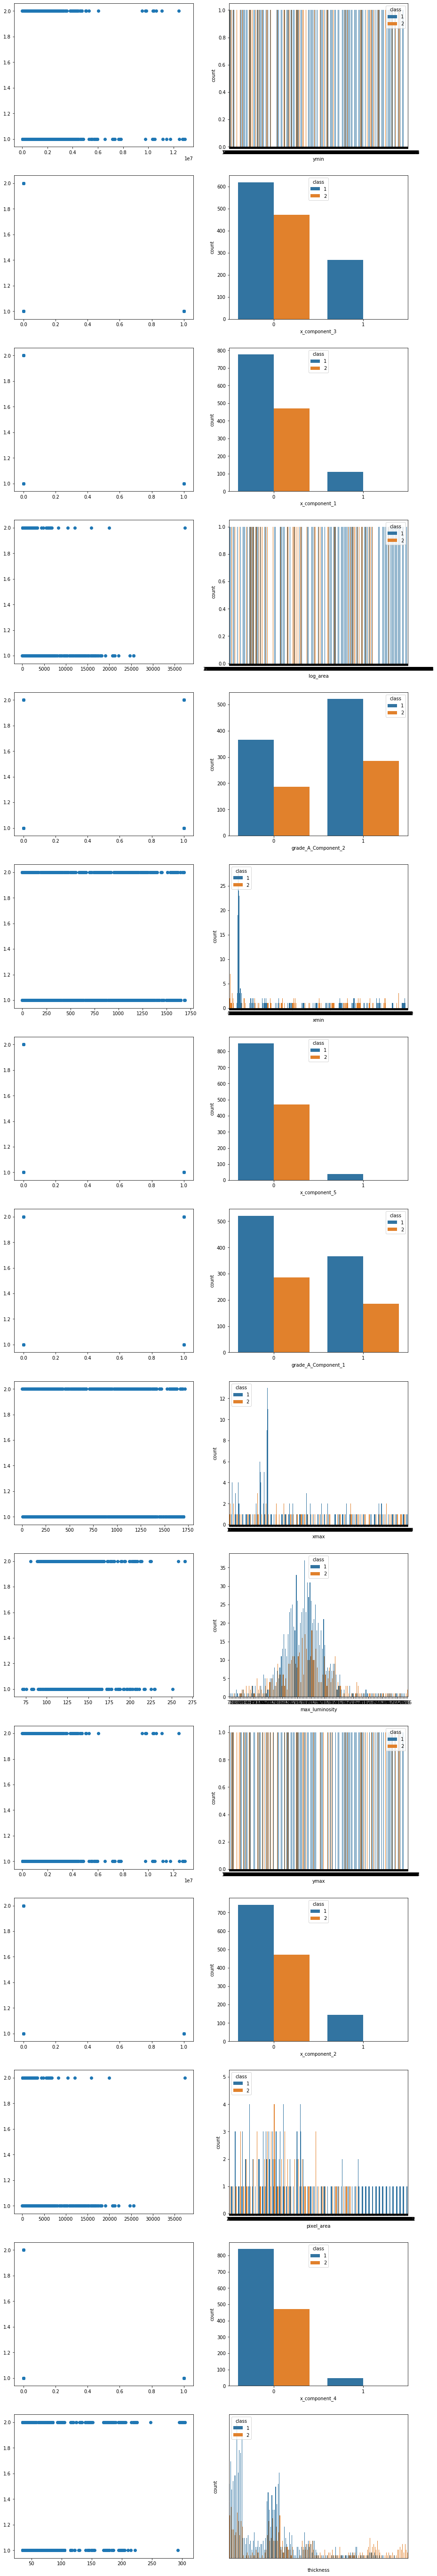

In [7]:
fig, ax = plt.subplots(15,2,figsize = (15,100) )
i = 0
for col in preidictor_columns:
    j = 0
    ax[i,j].scatter(train_df[col], train_df['class'])
    sns.countplot(train_df[col], ax = ax[i,j+1], hue = train_df['class'])
    ax[i,j].tick_params(colors='white', labelcolor = 'white')
    i+=1
plt.show()

In [14]:
len(train_df.columns)

16

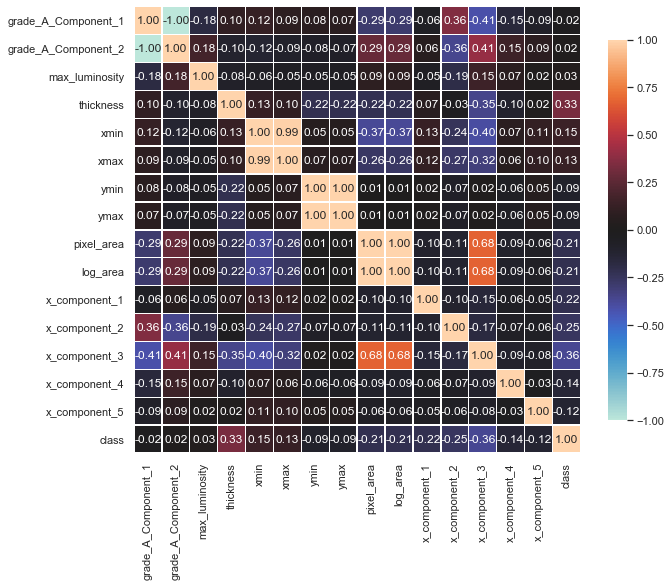

In [13]:
#There seems to be a correlation between pixel_area and log_area. So find all correlation.
sns.set(style="white")
corr = train_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})

There seems to be correlation with [xmin, xmax], [ymin, ymax], [pixel_area, log_area]
And grade_A_Component_1 is the exact opposite of grade_A_Component_2. So any on is enough.
So let's remove ['xmax', 'ymax', 'pixel_area', 'grade_A_Component_2']

### With selected predictors

In [4]:
predictor_columns = list(set(preidictor_columns) - set(['xmax', 'ymax', 'pixel_area', 'grade_A_Component_2']))

In [ ]:
#The classes here are  [1,2]
#for the below columns if the values are 1, then the class is also 1. i.e first probability
['x_component_1','x_component_2', 'x_component_3', 'x_component_4',  'x_component_5']

In [63]:
X = train_df[predictor_columns]
y = train_df['class']
X_test = test_df[predictor_columns]
print(X.shape)
print(X_test.shape)

(1358, 11)
(583, 11)


In [16]:
predictor_columns

['xmin',
 'ymin',
 'x_component_3',
 'x_component_5',
 'grade_A_Component_1',
 'x_component_1',
 'max_luminosity',
 'log_area',
 'x_component_2',
 'x_component_4',
 'thickness']

In [19]:
y = y-1 #changing grade 1 to 0 and grade 2 to 1
print(y.value_counts())

0    887
1    471
Name: class, dtype: int64


In [22]:
#Grid Search CV for XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
classifier_1 = XGBClassifier(random_state = 0)
params = {'max_depth' : [13,14,15], 'learning_rate' : [0.01, 0.03, 0.05, 0.1, 0.3, 0.5], 
         'estimators' : [150, 200, 300, 400], 'reg_lambda' : [0.01,0.03]}
grid_1 = GridSearchCV(estimator = classifier_1, param_grid = params, cv = 4, scoring = 'neg_log_loss')
grid_1.fit(X,y)
print("Score", grid_1.best_score_)
print("Params", grid_1.best_params_)

Score -0.30625639831680485
Params {'estimators': 150, 'learning_rate': 0.03, 'max_depth': 13, 'reg_lambda': 0.01}


In [31]:
grid_1.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_estimators', 'param_learning_rate', 'param_max_depth', 'param_reg_lambda', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
grid_1.cv_results_['mean_test_score']

In [29]:
np.where(grid_1.cv_results_['mean_test_score'] == -0.30625639831680485)[0]

array([  6,  42,  78, 114], dtype=int64)

In [34]:
print(grid_1.cv_results_['params'][6])
print(grid_1.cv_results_['params'][42])
print(grid_1.cv_results_['params'][78])
print(grid_1.cv_results_['params'][114])

{'estimators': 150, 'learning_rate': 0.03, 'max_depth': 13, 'reg_lambda': 0.01}
{'estimators': 200, 'learning_rate': 0.03, 'max_depth': 13, 'reg_lambda': 0.01}
{'estimators': 300, 'learning_rate': 0.03, 'max_depth': 13, 'reg_lambda': 0.01}
{'estimators': 400, 'learning_rate': 0.03, 'max_depth': 13, 'reg_lambda': 0.01}


In [36]:
params_2 = {'max_depth' : [10,11,12]}
classifier_1 = XGBClassifier(random_state = 0, estimators = 150, learning_rate = 0.03, reg_lambda = 0.01)
grid_2 = GridSearchCV(estimator = classifier_1, param_grid = params_2, cv = 4, scoring = 'neg_log_loss')
grid_2.fit(X,y)
print("Score", grid_2.best_score_)
print("Params", grid_2.best_params_)

Score -0.3025410331400577
Params {'max_depth': 11}


In [39]:
params_3 = {'estimators' : [70,100, 150]}
classifier_1 = XGBClassifier(random_state = 0, learning_rate = 0.03, reg_lambda = 0.01, max_depth = 11)
grid_3 = GridSearchCV(estimator = classifier_1, param_grid = params_3, cv = 4, scoring = 'neg_log_loss')
grid_3.fit(X,y)
print("Score", grid_3.best_score_)
print("Params", grid_3.best_params_)

Score -0.3025410331400577
Params {'estimators': 70}


In [40]:
np.where(grid_3.cv_results_['mean_test_score'] == -0.3025410331400577)[0]

array([0, 1, 2], dtype=int64)

In [42]:
X_test.shape

(583, 11)

In [64]:
classifier_1 = XGBClassifier(random_state = 0, estimators = 70, learning_rate = 0.03, reg_lambda = 0.01,
                            max_depth =11)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier_1, X,y, cv=4, scoring = 'neg_log_loss')
scores.mean()

-0.3019124455207606

In [43]:
#full fit
classifier_1 = XGBClassifier(random_state = 0, estimators = 70, learning_rate = 0.03, reg_lambda = 0.01,
                            max_depth =11)
classifier_1.fit(X,y)
predictions_1 = classifier_1.predict_proba(X_test)

In [44]:
predictions_1

array([[0.9752858 , 0.02471417],
       [0.20363194, 0.79636806],
       [0.9752647 , 0.02473529],
       ...,
       [0.9753188 , 0.02468119],
       [0.9752647 , 0.02473529],
       [0.9697989 , 0.03020108]], dtype=float32)

In [46]:
submissions_df = pd.DataFrame({'1':predictions_1[:,0], '2':predictions_1[:,1]})
print(submissions_df.shape)
submissions_df.head()

(583, 2)


,1,2
0,0.975286,0.024714
1,0.203632,0.796368
2,0.975265,0.024735
3,0.975319,0.024681
4,0.520513,0.479487


In [47]:
submissions_df.to_excel('Submissions_xgb.xlsx', index = False)

### With all predictors

In [57]:
all_predictor_columns = predictor_columns + ['xmax', 'ymax', 'pixel_area']
all_predictor_columns

['thickness',
 'grade_A_Component_1',
 'xmin',
 'x_component_3',
 'log_area',
 'max_luminosity',
 'x_component_5',
 'x_component_2',
 'x_component_4',
 'ymin',
 'x_component_1',
 'xmax',
 'ymax',
 'pixel_area']

In [58]:
X = train_df[all_predictor_columns]
y = train_df['class']
y = y-1
X_test = test_df[all_predictor_columns]
print(X.shape)
print(X_test.shape)

(1358, 14)
(583, 14)


In [55]:
#Grid Search CV for XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
classifier_2 = XGBClassifier(random_state = 0)
params = {'max_depth' : [10,11], 'learning_rate' : [0.01, 0.03, 0.05], 
         'estimators' : [70,100,150], 'reg_lambda' : [0.01,0.03]}
grid_4 = GridSearchCV(estimator = classifier_2, param_grid = params, cv = 4, scoring = 'neg_log_loss')
grid_4.fit(X,y)
print("Score", grid_4.best_score_)
print("Params", grid_4.best_params_)

Score -0.2994501299431399
Params {'estimators': 70, 'learning_rate': 0.05, 'max_depth': 10, 'reg_lambda': 0.01}


In [61]:
classifier_2 = XGBClassifier(random_state = 0, estimators = 70, learning_rate= 0.05, max_depth= 10, reg_lambda= 0.01)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier_2, X,y, cv=4, scoring = 'neg_log_loss')
scores.mean()

-0.30304434361700894

In [56]:
classifier_2 = XGBClassifier(random_state = 0, estimators = 70, learning_rate= 0.05, max_depth= 10, reg_lambda= 0.01)
classifier_2.fit(X,y)
predictions_2 = classifier_2.predict_proba(X_test)
predictions_2

array([[0.9934881 , 0.00651195],
       [0.15878183, 0.8412182 ],
       [0.9921656 , 0.00783438],
       ...,
       [0.9961069 , 0.0038931 ],
       [0.9876972 , 0.0123028 ],
       [0.9844913 , 0.01550872]], dtype=float32)

In [65]:
pd.Series(index = all_predictor_columns, data = classifier_2.feature_importances_).sort_values()

pixel_area             0.000000
ymax                   0.015449
log_area               0.017467
xmin                   0.019080
xmax                   0.019989
ymin                   0.022062
max_luminosity         0.022149
thickness              0.034295
grade_A_Component_1    0.066098
x_component_5          0.091916
x_component_4          0.100814
x_component_2          0.180907
x_component_1          0.185153
x_component_3          0.224622
dtype: float32

In [57]:
submissions_df_2 = pd.DataFrame({'1':predictions_2[:,0], '2':predictions_2[:,1]})
print(submissions_df_2.shape)
submissions_df_2.head()

(583, 2)


,1,2
0,0.993488,0.006512
1,0.158782,0.841218
2,0.992166,0.007834
3,0.996293,0.003707
4,0.494410,0.505590


In [66]:
submissions_df_2.to_excel('Submissions_xgb_2.xlsx', index = False)

In [69]:
from sklearn.metrics import log_loss
print(log_loss([0], [[0.9934881 , 0.00651195]], labels = [0,1]))
print(log_loss([0], [[0.9752858 , 0.02471417]], labels = [0,1]))

0.0065332449180637514
0.02502469273283979


#### The one with all predictors is useless. Because they just decrease the accuracy. Causes overfit

### Try with filter

In [6]:
filtered_with_1_train = train_df[(train_df['x_component_1'] == 1) | (train_df['x_component_2'] == 1) | (train_df['x_component_3'] == 1 ) | (train_df['x_component_4'] == 1) | (train_df['x_component_5'] == 1)]      

In [7]:
filtered_with_1_train.shape

(609, 16)

In [8]:
filtered_with_1_test = test_df[(test_df['x_component_1'] == 1) | (test_df['x_component_2'] == 1) | (test_df['x_component_3'] == 1 ) | (test_df['x_component_4'] == 1) | (test_df['x_component_5'] == 1)] 

In [9]:
filtered_with_1_test.shape

(257, 15)

In [77]:
X = train_df[predictor_columns]
y = train_df['class']
y=y-1
X_test = test_df[predictor_columns]
print(X.shape)
print(X_test.shape)

(1358, 11)
(583, 11)


In [78]:
#full fit
classifier_1 = XGBClassifier(random_state = 0, estimators = 70, learning_rate = 0.03, reg_lambda = 0.01,
                            max_depth =11)
classifier_1.fit(X,y)
predictions_3 = classifier_1.predict_proba(X_test)  

#### The best until now

In [ ]:
pd.Series(index = predictor_columns, data = classifier_1.feature_importances_).sort_values()

In [79]:
predictions_3

array([[0.9752858 , 0.02471417],
       [0.20363194, 0.79636806],
       [0.9752647 , 0.02473529],
       ...,
       [0.9753188 , 0.02468119],
       [0.9752647 , 0.02473529],
       [0.9697989 , 0.03020108]], dtype=float32)

In [81]:
submissions_df_3 = pd.DataFrame({'1':predictions_3[:,0], '2':predictions_3[:,1]})
submissions_df_3.loc[filtered_with_1_test.index, '1'] = 1
submissions_df_3.loc[filtered_with_1_test.index, '2'] = 0
print(submissions_df_3.shape)
submissions_df_3.head()

(583, 2)


,1,2
0,1.000000,0.000000
1,0.203632,0.796368
2,1.000000,0.000000
3,1.000000,0.000000
4,0.520513,0.479487


In [82]:
submissions_df_3.to_excel('Submissions_xgb_with_filter.xlsx', index = False)

In [107]:
submissions_df_2.head()

,1,2
0,0.993488,0.006512
1,0.158782,0.841218
2,0.992166,0.007834
3,0.996293,0.003707
4,0.494410,0.505590


### Adding Features

In [86]:
predictor_columns['max_luminosity'],predictor_columns['thickness']

['xmin',
 'ymin',
 'x_component_3',
 'x_component_5',
 'grade_A_Component_1',
 'x_component_1',
 'max_luminosity',
 'log_area',
 'x_component_2',
 'x_component_4',
 'thickness']

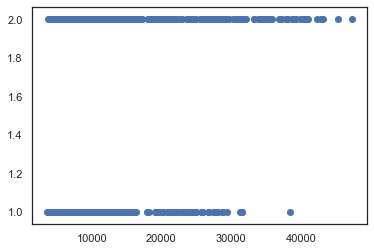

In [91]:
plt.scatter(train_df['max_luminosity']*train_df['thickness'], train_df['class'])

In [50]:
X = train_df[predictor_columns]
X['lum_x_thick'] = X['max_luminosity']*X['thickness']
y = train_df['class']
y=y-1
X_test = test_df[predictor_columns]
X_test['lum_x_thick'] = X_test['max_luminosity']*X_test['thickness']
print(X.shape)
print(X_test.shape)

(1358, 12)
(583, 12)


C:\Users\haripriyar\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\haripriyar\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
X.head()

,thickness,grade_A_Component_1,xmin,x_component_3,log_area,max_luminosity,x_component_5,x_component_2,x_component_4,ymin,x_component_1,lum_x_thick
0,36,0,144,1,439.099273,150,0,0,0,947225,0,5400
1,55,1,1144,0,329.205616,134,0,0,0,2379058,1,7370
2,65,1,950,0,300.120598,135,0,0,0,1038442,0,8775
3,35,0,41,1,6803.778622,123,0,0,0,1705580,0,4305
4,69,1,462,0,251.401943,138,0,0,0,1088124,0,9522


In [95]:
#Correct Grid Search with XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
params = {'max_depth' : [10,11,12,13], 'learning_rate' : [0.01, 0.03, 0.05, 0.1], 
         'n_estimators' : [70,100,200], 'reg_lambda' : [0.01,0.03]}
classifier_5 = XGBClassifier(random_state = 0)
grid_5 = GridSearchCV(estimator = classifier_5, param_grid = params, cv = 4, scoring = 'neg_log_loss')
grid_5.fit(X,y)
print("Score", grid_5.best_score_)
print("Params", grid_5.best_params_)

Score -0.2993791913442039
Params {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'reg_lambda': 0.01}


In [56]:
classifier_5 = XGBClassifier(random_state = 0, learning_rate = 0.05, max_depth = 10, n_estimators = 100, reg_lambda = 0.01)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier_5, X,y, cv=4, scoring = 'neg_log_loss')
scores.mean()

-0.3034310647837958

In [55]:
classifier_5.fit(X,y)
predictions_5 = classifier_5.predict_proba(X_test)

In [100]:
pd.Series(index = predictor_columns + ['lum_x_thick'], data = classifier_5.feature_importances_).sort_values()

log_area               0.018476
xmin                   0.020668
max_luminosity         0.022065
ymin                   0.023379
thickness              0.025909
lum_x_thick            0.036240
grade_A_Component_1    0.070425
x_component_5          0.081754
x_component_4          0.096676
x_component_2          0.186552
x_component_1          0.188942
x_component_3          0.228915
dtype: float32

In [105]:
predictions_5

array([[0.9936301 , 0.00636988],
       [0.35921174, 0.64078826],
       [0.99084127, 0.00915872],
       ...,
       [0.99616843, 0.00383159],
       [0.9840306 , 0.0159694 ],
       [0.9806322 , 0.01936782]], dtype=float32)

In [104]:
submissions_df_5 = pd.DataFrame({'1':predictions_5[:,0], '2':predictions_5[:,1]})
submissions_df_5.loc[filtered_with_1_test.index, '1'] = 1
submissions_df_5.loc[filtered_with_1_test.index, '2'] = 0
print(submissions_df_5.shape)
submissions_df_5.head()

(583, 2)


,1,2
0,1.000000,0.000000
1,0.359212,0.640788
2,1.000000,0.000000
3,1.000000,0.000000
4,0.500105,0.499895


In [108]:
submissions_df_5.to_excel('Submissions_with_added_feature.xlsx', index = False)

#### It did not do any good.

In [109]:
X = train_df[predictor_columns]
y = train_df['class']
y=y-1
X_test = test_df[predictor_columns]
print(X.shape)
print(X_test.shape)

(1358, 11)
(583, 11)


In [113]:
#full fit
classifier_1 = XGBClassifier(random_state = 0, n_estimators = 100, learning_rate = 0.05, reg_lambda = 0.01,
                            max_depth =11)
classifier_1.fit(X,y)
predictions_6 = classifier_1.predict_proba(X_test)

In [114]:
pd.Series(index = predictor_columns , data = classifier_1.feature_importances_).sort_values()

log_area               0.017111
max_luminosity         0.019195
xmin                   0.020452
ymin                   0.021017
thickness              0.029787
grade_A_Component_1    0.075192
x_component_5          0.097982
x_component_4          0.107147
x_component_2          0.188995
x_component_1          0.191693
x_component_3          0.231429
dtype: float32

In [115]:
predictions_6 

array([[0.99415225, 0.00584776],
       [0.23917806, 0.76082194],
       [0.99297976, 0.00702022],
       ...,
       [0.9961943 , 0.00380568],
       [0.9875819 , 0.01241812],
       [0.9747299 , 0.02527009]], dtype=float32)

In [116]:
submissions_df_6 = pd.DataFrame({'1':predictions_6[:,0], '2':predictions_6[:,1]})
submissions_df_6.loc[filtered_with_1_test.index, '1'] = 1
submissions_df_6.loc[filtered_with_1_test.index, '2'] = 0
print(submissions_df_6.shape)
submissions_df_6.head()

(583, 2)


,1,2
0,1.000000,0.000000
1,0.239178,0.760822
2,1.000000,0.000000
3,1.000000,0.000000
4,0.700137,0.299863


In [117]:
submissions_df_6.to_excel('Submission_with_lr_0.05.xlsx', index = False)

### Catboost

In [ ]:

from catboost import CatBoostClassifier
cat_features = ['grade_A_Component_1','x_component_5','x_component_4','x_component_2','x_component_1','x_component_3',]
params = {'depth' : [10,11], 'learning_rate' : [0.03, 0.05], 
         'n_estimators' : [100,200], 'reg_lambda' : [0.01,0.03]}
classifier_6 = CatBoostClassifier(random_state = 0, cat_features = cat_features)
grid_6 = GridSearchCV(estimator = classifier_6, param_grid = params, cv = 4, scoring = 'neg_log_loss')
grid_6.fit(X,y)
print("Score", grid_6.best_score_)
print("Params", grid_6.best_params_)

In [120]:
print("Score", grid_6.best_score_)
print("Params", grid_6.best_params_)

Score -0.30862872958603893
Params {'depth': 10, 'learning_rate': 0.05, 'n_estimators': 100, 'reg_lambda': 0.03}


In [121]:
### Catboost
from catboost import CatBoostClassifier
cat_features = ['grade_A_Component_1','x_component_5','x_component_4','x_component_2','x_component_1','x_component_3',]
params = {'depth' : [6,8,9], 'learning_rate' : [0.07, 0.08], 
         'n_estimators' : [100,200]}
classifier_6 = CatBoostClassifier(random_state = 0, cat_features = cat_features, reg_lambda =0.03, silent = True)
grid_6 = GridSearchCV(estimator = classifier_6, param_grid = params, cv = 4, scoring = 'neg_log_loss')
grid_6.fit(X,y)
print("Score", grid_6.best_score_)
print("Params", grid_6.best_params_)

Score -0.2997688105710117
Params {'depth': 8, 'learning_rate': 0.07, 'n_estimators': 100}


In [ ]:
classifier_6 = CatBoostClassifier(random_state = 0, cat_features = cat_features,
                                  reg_lambda =0.03, depth = 8, learning_rate = 0.07, n_estimators = 100)
classifier_6.fit(X,y)

In [124]:
predictions_7 = classifier_6.predict_proba(X_test)
submissions_df_7 = pd.DataFrame({'1':predictions_7[:,0], '2':predictions_7[:,1]})
submissions_df_7.loc[filtered_with_1_test.index, '1'] = 1
submissions_df_7.loc[filtered_with_1_test.index, '2'] = 0
print(submissions_df_7.shape)
submissions_df_7.head()

(583, 2)


,1,2
0,1.000000,0.000000
1,0.247477,0.752523
2,1.000000,0.000000
3,1.000000,0.000000
4,0.663890,0.336110


In [126]:
pd.Series(index = classifier_6.feature_names_ , data = classifier_6.feature_importances_).sort_values()

x_component_5           3.132894
x_component_4           3.957831
log_area                7.913699
max_luminosity          8.370171
grade_A_Component_1     8.725151
ymin                    8.790859
xmin                    8.862008
x_component_2          10.616751
x_component_1          11.664711
thickness              12.543128
x_component_3          15.422797
dtype: float64

In [127]:
submissions_df_7.to_excel('Submission_catboost.xlsx', index = False)

#### Training only with filtered X

In [5]:
X = train_df[predictor_columns]
y = train_df['class']
y=y-1
X_test = test_df[predictor_columns]
print(X.shape)
print(X_test.shape)

(1358, 11)
(583, 11)


In [10]:
filtered_with_1_train.shape

(609, 16)

In [29]:
selected_X = X.drop(filtered_with_1_train.index, axis = 0)
selected_y = y.drop(filtered_with_1_train.index, axis = 0)
print(selected_X.shape)
print(selected_y.shape)

(749, 11)
(749,)


In [16]:
#full fit
from xgboost import XGBClassifier
classifier_8 = XGBClassifier(random_state = 0, n_estimators = 100, learning_rate = 0.03, reg_lambda = 0.01,
                            max_depth =11)
classifier_8.fit(X,y) #wrongly done but stil improved
predictions_8 = classifier_8.predict_proba(X_test)

In [17]:
pd.Series(index = predictor_columns , data = classifier_8.feature_importances_).sort_values()

log_area               0.016145
xmin                   0.017582
max_luminosity         0.018515
ymin                   0.020166
thickness              0.029982
grade_A_Component_1    0.079500
x_component_5          0.081116
x_component_4          0.089952
x_component_1          0.186475
x_component_2          0.193839
x_component_3          0.266727
dtype: float32

In [18]:
submissions_df_8 = pd.DataFrame({'1':predictions_8[:,0], '2':predictions_8[:,1]})
submissions_df_8.loc[filtered_with_1_test.index, '1'] = 1
submissions_df_8.loc[filtered_with_1_test.index, '2'] = 0
print(submissions_df_8.shape)
submissions_df_8.head()

(583, 2)


,1,2
0,1.000000,0.000000
1,0.154214,0.845786
2,1.000000,0.000000
3,1.000000,0.000000
4,0.475937,0.524063


In [19]:
submissions_df_8.to_excel('Submission_with_filtered_train.xlsx', index = False)

In [25]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier_8, X,y, cv=4, scoring = 'neg_log_loss')

In [26]:
scores.mean() #-0.3019124455207606

-0.3019124455207606

In [34]:
#full fit
from xgboost import XGBClassifier
classifier_9 = XGBClassifier(random_state = 0, n_estimators = 100, learning_rate = 0.03, reg_lambda = 0.01,
                            max_depth =11)
classifier_9.fit(selected_X,selected_y) #wrongly done but stil improved
predictions_9 = classifier_9.predict_proba(X_test)

In [35]:
pd.Series(index = predictor_columns , data = classifier_9.feature_importances_).sort_values()

x_component_3          0.000000
x_component_5          0.000000
x_component_2          0.000000
x_component_4          0.000000
x_component_1          0.000000
log_area               0.089394
xmin                   0.100001
max_luminosity         0.101885
ymin                   0.117955
thickness              0.138315
grade_A_Component_1    0.452450
dtype: float32

In [39]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier_9, selected_X,selected_y, cv=4, scoring = 'neg_log_loss')
scores.mean()

-0.5369257165002703

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1222, 11) (136, 11) (1222,) (136,)


In [49]:
classifier_9.fit(X_train.drop(filtered_with_1_train.index, errors = 'ignore'),
                 y_train.drop(filtered_with_1_train.index, errors = 'ignore'))
y_val_pred = classifier_9.predict_proba(X_val)
from sklearn.metrics import log_loss
log_loss(y_val,y_val_pred[:,1])

0.9610785304787842

In [36]:
submissions_df_9 = pd.DataFrame({'1':predictions_9[:,0], '2':predictions_9[:,1]})
submissions_df_9.loc[filtered_with_1_test.index, '1'] = 1
submissions_df_9.loc[filtered_with_1_test.index, '2'] = 0
print(submissions_df_9.shape)
submissions_df_9.head()

(583, 2)


,1,2
0,1.000000,0.000000
1,0.148796,0.851204
2,1.000000,0.000000
3,1.000000,0.000000
4,0.469882,0.530118


In [37]:
submissions_df_9.to_excel('Submission_with_filtered_train_correct.xlsx', index = False)

#### Above method Not useful

#### With ['xmax', 'ymax']

In [65]:
X = train_df[predictor_columns + ['xmax', 'ymax']]
y = train_df['class']
y=y-1
X_test = test_df[predictor_columns + ['xmax', 'ymax']]
print(X.shape)
print(X_test.shape)

(1358, 13)
(583, 13)


In [66]:
#Correct Grid Search with XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
params = {'max_depth' : [10,11,12], 'learning_rate' : [0.01, 0.03, 0.05, 0.1], 
         'n_estimators' : [100,150], 'reg_lambda' : [0.01,0.03]}
classifier_10 = XGBClassifier(random_state = 0)
grid_10 = GridSearchCV(estimator = classifier_10, param_grid = params, cv = 4, scoring = 'neg_log_loss')
grid_10.fit(X,y)
print("Score", grid_10.best_score_)
print("Params", grid_10.best_params_)

Score -0.29704339502249977
Params {'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 150, 'reg_lambda': 0.03}


In [67]:
print("Estimator", grid_10.best_estimator_)

Estimator XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=0.03, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)


In [69]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(grid_10.best_estimator_, X,y ,cv=4, scoring = 'neg_log_loss')
scores.mean()

-0.29704339502249977

In [70]:
classifier_10 = XGBClassifier(random_state = 0, learning_rate= 0.03, max_depth= 10, n_estimators= 150, reg_lambda = 0.03)
scores = cross_val_score(grid_10.best_estimator_, X,y ,cv=4, scoring = 'neg_log_loss')
scores.mean()

-0.29704339502249977

In [71]:
#full fit
from xgboost import XGBClassifier
grid_10.best_estimator_.fit(X,y) 
predictions_10 = grid_10.best_estimator_.predict_proba(X_test)

In [72]:
submissions_df_10 = pd.DataFrame({'1':predictions_10[:,0], '2':predictions_10[:,1]})
submissions_df_10.loc[filtered_with_1_test.index, '1'] = 1
submissions_df_10.loc[filtered_with_1_test.index, '2'] = 0
print(submissions_df_10.shape)
submissions_df_10.head()

(583, 2)


,1,2
0,1.000000,0.000000
1,0.170817,0.829183
2,1.000000,0.000000
3,1.000000,0.000000
4,0.572580,0.427420


In [73]:
submissions_df_10.to_excel('Submission_with_xmax_ymax.xlsx', index = False)

### Other feaTures

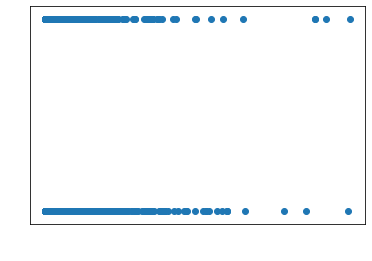

In [78]:
import matplotlib.pyplot as plt
plt.scatter(train_df['xmin']*train_df['ymin'], train_df['class'])
plt.tick_params(colors='white', labelcolor = 'white')

In [ ]:
X = train_df[predictor_columns]
X['xmin_x_ymin'] = X['xmin']*X['ymin']
y = train_df['class']
y=y-1
X_test = test_df[predictor_columns]
X_test['xmin_x_ymin'] = X_test['xmin']*X_test['ymin']
print(X.shape)
print(X_test.shape)

In [84]:
X.head()

,thickness,grade_A_Component_1,xmin,x_component_3,log_area,max_luminosity,x_component_5,x_component_2,x_component_4,ymin,x_component_1,xmin_x_ymin
0,36,0,144,1,439.099273,150,0,0,0,947225,0,136400400
1,55,1,1144,0,329.205616,134,0,0,0,2379058,1,2721642352
2,65,1,950,0,300.120598,135,0,0,0,1038442,0,986519900
3,35,0,41,1,6803.778622,123,0,0,0,1705580,0,69928780
4,69,1,462,0,251.401943,138,0,0,0,1088124,0,502713288


In [80]:
#Correct Grid Search with XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
params = {'max_depth' : [10,11,12], 'learning_rate' : [0.01, 0.03, 0.05, 0.1], 
         'n_estimators' : [100,150], 'reg_lambda' : [0.01,0.03]}
classifier_11 = XGBClassifier(random_state = 0)
grid_11 = GridSearchCV(estimator = classifier_11, param_grid = params, cv = 4, scoring = 'neg_log_loss')
grid_11.fit(X,y)
print("Score", grid_11.best_score_)
print("Params", grid_11.best_params_)

Score -0.29553497507348486
Params {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'reg_lambda': 0.03}


In [81]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(grid_11.best_estimator_, X,y ,cv=4, scoring = 'neg_log_loss')
scores.mean()

-0.29553497507348486

In [82]:
#full fit
from xgboost import XGBClassifier
grid_11.best_estimator_.fit(X,y) 
predictions_11 = grid_11.best_estimator_.predict_proba(X_test)

In [86]:
pd.Series(index = predictor_columns + ['xmin_x_ymin'] , data = grid_11.best_estimator_.feature_importances_).sort_values()

log_area               0.019152
xmin                   0.019769
xmin_x_ymin            0.021380
ymin                   0.022552
max_luminosity         0.023885
thickness              0.031412
grade_A_Component_1    0.081341
x_component_5          0.093325
x_component_4          0.107474
x_component_2          0.178196
x_component_1          0.182379
x_component_3          0.219134
dtype: float32

In [83]:
submissions_df_11 = pd.DataFrame({'1':predictions_11[:,0], '2':predictions_11[:,1]})
submissions_df_11.loc[filtered_with_1_test.index, '1'] = 1
submissions_df_11.loc[filtered_with_1_test.index, '2'] = 0
print(submissions_df_11.shape)
submissions_df_11.head()

(583, 2)


,1,2
0,1.000000,0.000000
1,0.152471,0.847529
2,1.000000,0.000000
3,1.000000,0.000000
4,0.506617,0.493383


In [87]:
submissions_df_11.to_excel('Submission_with_xmin_x_ymin.xlsx', index = False)

### Other technique

In [5]:
X = train_df[predictor_columns]
y = train_df['class']
y=y-1
X_test = test_df[predictor_columns]
print(X.shape)
print(X_test.shape)

(1358, 11)
(583, 11)


In [90]:
print((train_df.loc[0,'xmax'] - train_df.loc[0,'xmin']) * (train_df.loc[0,'ymax'] - train_df.loc[0,'ymin']))
print(train_df.loc[0,'pixel_area'])

2996
439


In [ ]:
train_df[train_df['xmin'] > train_df['xmax']].any()

In [96]:
train_df[train_df['ymin'] > train_df['ymax']].any()

grade_A_Component_1    True
grade_A_Component_2    True
max_luminosity         True
thickness              True
xmin                   True
xmax                   True
ymin                   True
ymax                   True
pixel_area             True
log_area               True
x_component_1          True
x_component_2          True
x_component_3          True
x_component_4          True
x_component_5          True
class                  True
dtype: bool

In [95]:
train_df[train_df['ymax'] - train_df['ymin'] < 0][['ymax','ymin']]

,ymax,ymin
2,1036754,1038442
4,1086579,1088124
5,1136929,1137516
6,87169,87212
7,696534,697615
...,...,...
1347,2473087,2474146
1349,1424209,1424645
1351,849054,849397
1352,142886,143000


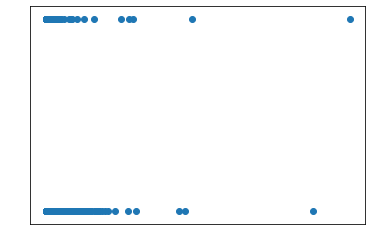

In [111]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
plt.scatter(sc.fit_transform(
    np.array(abs((train_df['ymax'] - train_df['ymin']) * (train_df['xmax'] - train_df['xmin']))).reshape(-1,1)), train_df['class'])
plt.tick_params(colors='white', labelcolor = 'white')

In [ ]:
X = train_df[predictor_columns]
X['xmax-xmin'] = abs(train_df.loc[:,'xmax'] - train_df.loc[:,'xmin'])
X['ymax-ymin'] = abs(train_df.loc[:,'ymax'] - train_df.loc[:,'ymin'])
X['volume'] = X['xmax-xmin'] * X['ymax-ymin'] * X['thickness']
y = train_df['class']
y=y-1
X_test = test_df[predictor_columns]
X_test['xmax-xmin'] = abs(test_df.loc[:,'xmax'] - test_df.loc[:,'xmin'])
X_test['ymax-ymin'] = abs(test_df.loc[:,'ymax'] - test_df.loc[:,'ymin'])
X_test['volume'] = X_test['xmax-xmin'] * X_test['ymax-ymin'] * X_test['thickness']
print(X.shape)
print(X_test.shape)


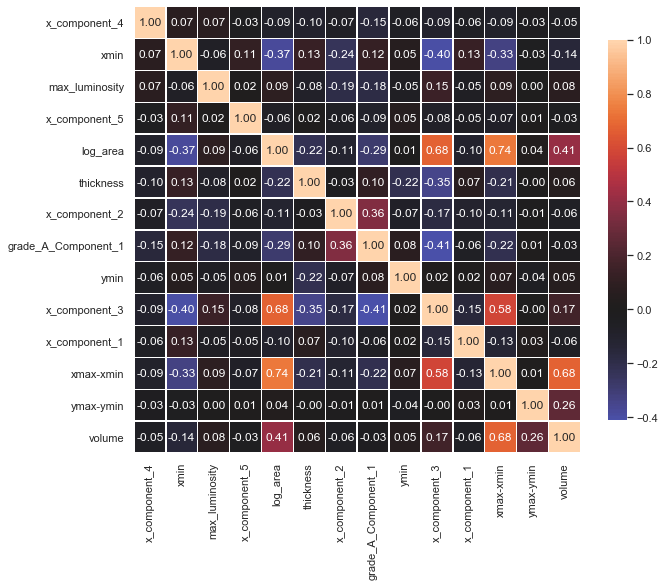

In [8]:
#There seems to be a correlation between pixel_area and log_area. So find all correlation.
sns.set(style="white")
corr = X.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})

In [124]:
#Correct Grid Search with XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
params = {'est__max_depth' : [10,11,12], 'est__learning_rate' : [0.01, 0.03, 0.05, 0.1], 
         'est__n_estimators' : [100,150], 'est__reg_lambda' : [0.01,0.03]}
classifier_12 = XGBClassifier(random_state = 0)
pipe = Pipeline([
    ('sc',StandardScaler()),('est',classifier_12)
])
grid_12 = GridSearchCV(estimator = pipe, param_grid = params, cv = 5, scoring = 'neg_log_loss')
grid_12.fit(X,y)
print("Score", grid_12.best_score_)
print("Params", grid_12.best_params_)

Score -0.29999829667251754
Params {'est__learning_rate': 0.05, 'est__max_depth': 10, 'est__n_estimators': 100, 'est__reg_lambda': 0.03}


In [129]:
#Params {'est__learning_rate': 0.03, 'est__max_depth': 11, 'est__n_estimators': 150, 'est__reg_lambda': 0.03}
from sklearn.model_selection import cross_val_score
scores = cross_val_score(grid_12.best_estimator_, X,y ,cv=4, scoring = 'neg_log_loss')
scores.mean()

-0.2946628055452142

In [117]:
#full fit
print(X.shape)
from xgboost import XGBClassifier
grid_12.best_estimator_.fit(X,y) 
predictions_12 = grid_12.best_estimator_.predict_proba(X_test)

(1358, 14)


In [130]:
pd.Series(index = predictor_columns + ['xmax-xmin','ymax-ymin','volume'] , data = grid_12.best_estimator_[1].feature_importances_).sort_values()

ymax-ymin              0.014300
volume                 0.016870
log_area               0.019706
xmax-xmin              0.021750
xmin                   0.022656
max_luminosity         0.022983
ymin                   0.023442
thickness              0.036014
grade_A_Component_1    0.066687
x_component_5          0.088083
x_component_4          0.097836
x_component_2          0.176473
x_component_1          0.178733
x_component_3          0.214466
dtype: float32

In [131]:
submissions_df_12 = pd.DataFrame({'1':predictions_12[:,0], '2':predictions_12[:,1]})
submissions_df_12.loc[filtered_with_1_test.index, '1'] = 1
submissions_df_12.loc[filtered_with_1_test.index, '2'] = 0
print(submissions_df_12.shape)
submissions_df_12.head()

(583, 2)


,1,2
0,1.000000,0.000000
1,0.137696,0.862304
2,1.000000,0.000000
3,1.000000,0.000000
4,0.473877,0.526123


In [121]:
submissions_df_12.to_excel('Submission_with_other_technique.xlsx', index = False)

In [132]:
submissions_df_12.to_excel('Submission_with_other_technique_1.xlsx', index = False)